In [ ]:
!pip install -q torchmetrics
from IPython.display import clear_output
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sshikamaru/car-object-detection
!unzip -q car-object-detection.zip
!rm car-object-detection.zip
clear_output()

In [ ]:
"""
# for real-world and real-time applications one of the most powerful approaches would be:
# SSD model, pretrained by NVIDIA

ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd')
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

ssd_model.to(device)
ssd_model.eval()

uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs)

with torch.no_grad():
    detections_batch = ssd_model(tensor)

results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

classes_to_labels = utils.get_coco_object_dictionary()

from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# that's it!
"""

total 100
drwxr-xr-x 4 root root  4096 Jan 25 20:58  .
drwxr-xr-x 1 root root  4096 Jan 25 20:58  ..
-rw-r--r-- 1 root root  2867 Aug 24  2020  sample_submission.csv
drwxr-xr-x 2 root root 12288 Jan 25 20:58  testing_images
drwxr-xr-x 2 root root 36864 Jan 25 20:58  training_images
-rw-r--r-- 1 root root 34798 Aug 24  2020 'train_solution_bounding_boxes (1).csv'


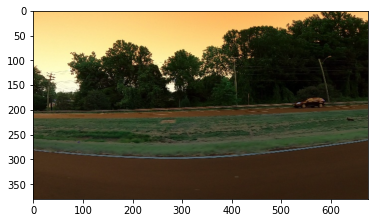

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path = r'./data/training_images/vid_4_9200.jpg'

img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv('data/train_solution_bounding_boxes (1).csv')
df.head()
# sub x by img_width, y by img_height h,w = img.shape[:2] and then multiply by 224 (faster RCNN size)

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [ ]:
len(df)

559

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torch import optim
from torchmetrics.detection.map import MeanAveragePrecision
from torchvision.ops import nms

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import cv2
import os
from tqdm.notebook import tqdm
from glob import glob

from sklearn.model_selection import train_test_split, StratifiedKFold

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_folder = r'./data/training_images/'
test_folder = r'./data/testing_images/'
data_root = r'data/train_solution_bounding_boxes (1).csv'

In [ ]:
labels_to_int = {'background': 0, 'car': 1}
int_to_labels = {0: 'background', 1: 'car'}

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
epochs = 50
num_classes = 2
PATH = os.path.join(os.getcwd() + '/model_weights.pth')
torch.manual_seed(1)

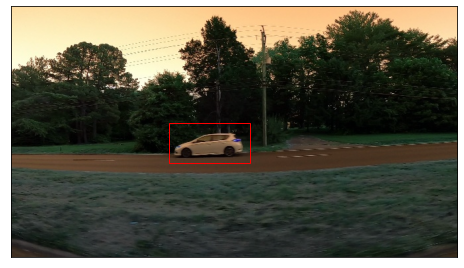

In [ ]:
plt.figure(figsize=(8,6))
img_name = 'vid_4_10040.jpg'
image = cv2.imread(train_folder + img_name)
df = pd.read_csv(data_root)
xmin, ymin, xmax, ymax = df.loc[df['image'] == 'vid_4_10040.jpg', ['xmin', 'ymin', 'xmax', 'ymax']].squeeze()
plt.imshow(image)
plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# optionally try without color transforms
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ColorJitter(brightness=(0.95, 1.05),
                                            contrast=(0.95, 1.05),
                                            saturation=(0.95, 1.05),
                                            hue=0.0),
                              T.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 2)),
                              T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
                              T.ToTensor()
])

valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                              T.ToTensor()
])

In [ ]:
boxes_df = pd.read_csv(data_root)
train_idx, valid_idx = train_test_split(boxes_df['image'].unique(), shuffle=True, test_size=0.08, random_state=1)

train, valid = boxes_df[boxes_df['image'].isin(train_idx)], boxes_df[boxes_df['image'].isin(valid_idx)]
train.shape, valid.shape

((514, 5), (45, 5))

In [ ]:
boxes_df['image'].nunique()

355

In [ ]:
class CarDataset(Dataset):
    def __init__(self, df, folder, transforms=None):
        self.df = df.copy()
        self.folder = folder
        self.transforms = transforms
        self.image_inf = self.df['image'].unique()

    def __len__(self):
        return len(self.image_inf)

    def __getitem__(self, ix):
        img_name = self.image_inf[ix]
        image = cv2.imread(self.folder + img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]
        if self.transforms is not None:
            image = self.transforms(image).to(device).float()
        data = self.df[self.df['image'] == img_name]
        labels = np.ones((len(data),)).tolist()
        data = data[['xmin', 'ymin', 'xmax', 'ymax']].values
        data[:, [0,2]] *= (IMAGE_SIZE / width)
        data[:, [1,3]] *= (IMAGE_SIZE / height)
        boxes = data.astype(np.uint32).tolist()
        target = {}
        target['boxes'] = torch.Tensor(boxes).float()
        target['labels'] = torch.Tensor([label for label in labels]).long()
        return image, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [ ]:
train_ds = CarDataset(train, train_folder, train_transforms)
valid_ds = CarDataset(valid, train_folder, valid_transforms)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_ds.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_ds.collate_fn, drop_last=True)

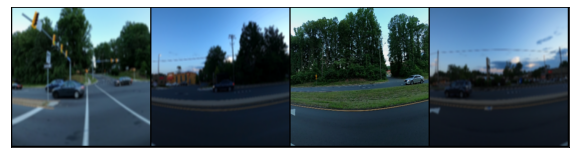

In [ ]:
plt.figure(figsize=(10,10))
disp_tensor = next(iter(train_dataloader))
grid_img = torchvision.utils.make_grid(list(disp_tensor[0]), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=PATH):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            torch.save(model.state_dict(), self.path)
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model.to(device)

In [ ]:
model = get_model()
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# optional apply StepLR with step=3
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, min_lr=5e-6)
early_stop = EarlyStopping()

In [ ]:
def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([i for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

def train_one_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets_ = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets_)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()

    model.eval()
    outputs = model(input)
    preds, target = [], []
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        pred = dict(
            boxes=torch.Tensor(bbs),
            scores=torch.Tensor(confs),
            labels=torch.IntTensor([label for label in labels])
        )
        tar = dict(
            boxes=targets[i]['boxes'],
            labels=targets[i]['labels']
        )
        preds.append(pred)
        target.append(tar)

    return loss, losses, preds, target

@torch.no_grad()
def validate(inputs, model):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets_ = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    optimizer.zero_grad()
    losses = model(input, targets_)
    loss = sum(loss for loss in losses.values())

    model.eval()
    outputs = model(input)
    preds, target = [], []
    for i, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        pred = dict(
            boxes=torch.Tensor(bbs),
            scores=torch.Tensor(confs),
            labels=torch.IntTensor([label for label in labels])
        )
        tar = dict(
            boxes=targets[i]['boxes'],
            labels=targets[i]['labels']
        )
        preds.append(pred)
        target.append(tar)

    return loss, losses, preds, target

In [ ]:
train_losses, valid_losses = [], []
train_metric = MeanAveragePrecision('xyxy')
valid_metric = MeanAveragePrecision('xyxy')

for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []

    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss, _, preds, target = train_one_batch(batch, model, optimizer)
        batch_train_loss = batch_train_loss.item()
        epoch_train_losses.append(batch_train_loss)
        train_metric.update(preds, target)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)
    map_train = train_metric.compute()['map']
    print(f'Train loss: {epoch_train_loss:.4f}, train mAP: {map_train.item():.4f}')

    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss, _, preds, target = validate(batch, model)
        batch_valid_loss = batch_valid_loss.item()
        epoch_valid_losses.append(batch_valid_loss)
        valid_metric.update(preds, target)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    map_valid = valid_metric.compute()['map']
    print(f'Valid loss: {epoch_valid_loss:.4f}, valid mAP: {map_valid.item():.4f}')
    print('-'*50)    

    scheduler.step(epoch_valid_loss)
    early_stop(epoch_valid_loss, model)
    if early_stop.early_stop:
        print(f'Validation loss did not improve for {early_stop.patience} epochs. Training stopped.')
        model.load_state_dict(torch.load(PATH))
        break

Epoch 1/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.2158, train mAP: 0.5411


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1483, valid mAP: 0.6440
--------------------------------------------------
Epoch 2/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.1447, train mAP: 0.5772


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1394, valid mAP: 0.6325
--------------------------------------------------
Epoch 3/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.1251, train mAP: 0.6002


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1412, valid mAP: 0.6278
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 4/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.1170, train mAP: 0.6165


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1453, valid mAP: 0.6218
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 5/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.1049, train mAP: 0.6323


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1368, valid mAP: 0.6230
--------------------------------------------------
Epoch 6/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0979, train mAP: 0.6444


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1379, valid mAP: 0.6281
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 7/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0874, train mAP: 0.6567


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1264, valid mAP: 0.6282
--------------------------------------------------
Epoch 8/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0796, train mAP: 0.6698


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1298, valid mAP: 0.6204
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 9/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0723, train mAP: 0.6805


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1238, valid mAP: 0.6210
--------------------------------------------------
Epoch 10/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0683, train mAP: 0.6892


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1282, valid mAP: 0.6219
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 11/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0597, train mAP: 0.7004


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1264, valid mAP: 0.6206
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 12/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0561, train mAP: 0.7108


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1235, valid mAP: 0.6210
--------------------------------------------------
Epoch 13/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0521, train mAP: 0.7168


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1275, valid mAP: 0.6212
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 14/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0522, train mAP: 0.7241


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1267, valid mAP: 0.6218
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 15/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0461, train mAP: 0.7312


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1230, valid mAP: 0.6203
--------------------------------------------------
Epoch 16/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0432, train mAP: 0.7362


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1224, valid mAP: 0.6207
--------------------------------------------------
Epoch 17/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0440, train mAP: 0.7418


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1265, valid mAP: 0.6186
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 18/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0443, train mAP: 0.7458


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1209, valid mAP: 0.6194
--------------------------------------------------
Epoch 19/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0462, train mAP: 0.7505


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1251, valid mAP: 0.6194
--------------------------------------------------
INFO: Early stopping counter 1 of 5
Epoch 20/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0394, train mAP: 0.7543


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1328, valid mAP: 0.6199
--------------------------------------------------
INFO: Early stopping counter 2 of 5
Epoch 21/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0384, train mAP: 0.7569


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1250, valid mAP: 0.6200
--------------------------------------------------
INFO: Early stopping counter 3 of 5
Epoch 22/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0360, train mAP: 0.7605


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1292, valid mAP: 0.6213
--------------------------------------------------
INFO: Early stopping counter 4 of 5
Epoch 23/50


  0%|          | 0/81 [00:00<?, ?it/s]

Train loss: 0.0287, train mAP: 0.7643


  0%|          | 0/7 [00:00<?, ?it/s]

Valid loss: 0.1227, valid mAP: 0.6221
--------------------------------------------------
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Validation loss did not improve for 5 epochs. Training stopped.


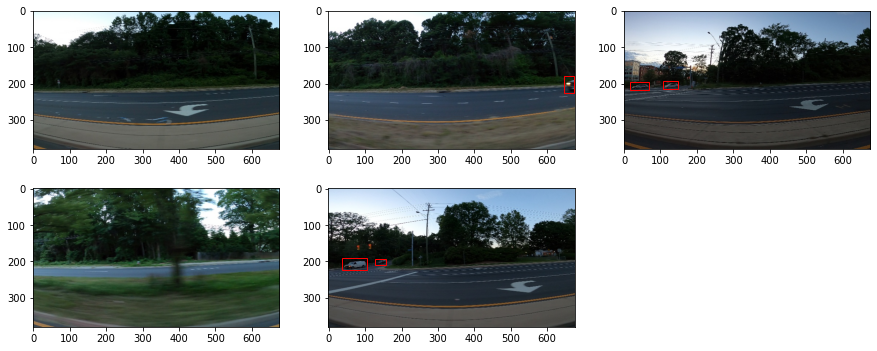

In [ ]:
test_data_paths = glob(test_folder + '/*')
paths = np.random.randint(len(test_data_paths), size=5)
plt.figure(figsize=(15,6))
for i, path in enumerate(paths):
    plt.subplot(2, 3, i+1)
    img = cv2.imread(str(test_data_paths[path]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    h, w = img.shape[:2]
    img = valid_transforms(img)[None].to(device).float()
    model.eval()
    output = model(img)
    bbs, confs, labels = decode_output(output[0])
    for bb in bbs:
        if len(bb) > 0:
            bb = np.array(bb).astype(np.float64)
            bb[[0,2]] *= (w / IMAGE_SIZE)
            bb[[1,3]] *= (h / IMAGE_SIZE)
            xmin, ymin, xmax, ymax = bb
            plt.gca().add_patch(Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none'))
plt.show()